In [1]:
import torch
import tqdm
import logger
import numpy as np
import torch.nn as nn
import pickle
import metrics
from skimage import io
from skimage import transform
# from model import FusionNet, DilationCNN, UNet
# from dataset import NucleiDataset, HPADataset, NeuroDataset, HPASingleDataset,get_augmenter
from torch.utils.data import DataLoader
from loss import dice_loss
import imageio


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import torchvision
import torchvision.models as tormodel
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import glob
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

def mkdir_if_missing(save_dir):
    if os.path.exists(save_dir):
        return 1
    else:
        os.makedirs(save_dir)
        return 0

# Dataloader

In [2]:
import torch.utils.data as data
from PIL import Image
import os

class GetLoader(data.Dataset):
    def __init__(self, data_root, img_folder, lab_folder, transform=None):
        self.img_root = os.path.join(data_root,img_folder)
        self.mask_root = os.path.join(data_root,lab_folder)
        self.transform = transform
        
        data_list = os.listdir(self.img_root)
        self.n_data = len(data_list)

        self.img_paths = []
        self.lab_paths = []

        for data in data_list:
            self.img_paths.append(os.path.join(self.img_root,data))
            self.lab_paths.append(os.path.join(self.mask_root,data))

    def __getitem__(self, item):
        img_pth, lab_pth = self.img_paths[item], self.lab_paths[item]
        imgs = Image.open(img_pth).convert('RGB')
        labels = np.asarray(imageio.imread(lab_pth))

        if self.transform is not None:
            imgs = self.transform(imgs)
#             labels = self.transform(labels)
        return imgs, labels

    def __len__(self):
        return self.n_data


In [3]:
DATA_DIR = '/home/zhangj41/HW/group_proj/Immune_cyto'
TRAIN_IMG = 'image_train'
TEST_IMG = 'image_test'
TRAIN_MASK = 'mask_train'
TEST_MASK = 'mask_test'

img_transform_train = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
])

'''---train loader---'''
DATASET_TRAIN = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TRAIN_IMG, 
    lab_folder=TRAIN_MASK, 
    transform=img_transform_train
)
DATALOADER_TRAIN = torch.utils.data.DataLoader(
    dataset=DATASET_TRAIN,
    batch_size=50,
    shuffle=True)

'''---test loader---'''
DATASET_TEST = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TEST_IMG, 
    lab_folder=TEST_MASK, 
    transform=img_transform_train
)
DATALOADER_TEST = torch.utils.data.DataLoader(
    dataset=DATASET_TEST,
    batch_size=100,
    shuffle=False)

34


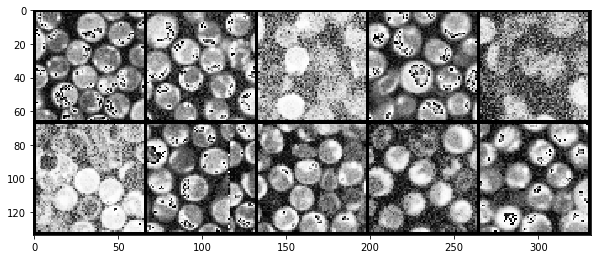

In [4]:
print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
batch_datas, batch_labels = next(iter(DATALOADER_TRAIN)) 
# print(batch_labels)
img = make_grid(batch_datas[0:10], nrow=5, padding=2)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [5]:
# batch_labels_ = batch_labels.unsqueeze(1)
# print(batch_labels_.size())
# img = make_grid(batch_labels_[0:10], nrow=5, padding=2)
# npimg = img.numpy()
# print(npimg.shape)
# plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray', interpolation='nearest')

In [6]:
batch_label = batch_labels[0]
batch_label.size()

torch.Size([64, 64])

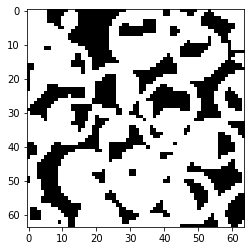

In [7]:
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

# Models

In [8]:
import torch.nn as nn 
import unet_layers as layers


class UNet(nn.Module):
    def __init__(self, num_kernel, kernel_size, dim, target_dim):
        super(UNet, self).__init__()
        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = target_dim

        # encode
        self.encode_1 = layers.DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = layers.DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = layers.DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = layers.DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = layers.UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = layers.UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = layers.UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = layers.UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):
        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)
        pred = self.activate(x)
        return pred

In [9]:
### debug
# batch_datas, batch_labels = next(iter(dataloader_train)) 
# batch_labels.unsqueeze_(1)
# batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()
# unet = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
# unet.cuda()


In [10]:
# loss_function = dice_loss
# pred = unet(batch_datas)
# print(batch_datas.size(), pred.size(), batch_labels.size())
# loss_function(pred, batch_labels)

In [11]:
# print(torch.min(pred),torch.max(pred))
# print(torch.min(batch_labels),torch.max(batch_labels))

# Utils

## Average meter

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Cell segmentation

In [13]:
class CellSeg:
    def __init__(self, unet):
        self.unet = unet
        self.unet.cuda()
        self.optimizer = torch.optim.SGD(self.unet.parameters(),
                                         lr=0.01, momentum=0.9, weight_decay=1e-3)
    
    def scheduler(self, epoch, lr0=1e-3):
        lr = lr0
        if epoch >= 120:
            lr = lr0 * 0.1
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

            
    def train_batch(self,
                    data_loader,
                    epoch):
        '''--- 1. setup network ---'''
        loss_function = dice_loss
#         total_loss = AverageMeter()
#         total_iou = AverageMeter()
#         total_precision = AverageMeter()
        
        # set train state
        self.unet.train()
        len_dataloader = len(data_loader)
        data_iter = iter(data_loader)

        '''--- 2. train network ---'''
        iters=0
        while iters<len_dataloader-1:
            iters+=1
            input_img, class_label = next(data_iter)
            class_label.unsqueeze_(1)
            input_img, class_label = input_img.cuda(), class_label.cuda()
            batch_size = len(class_label)
            '''forward, compute student ce loss'''
            pred_mask = self.unet(input_img)
            loss = loss_function(pred_mask, class_label)
            
            predictions = pred_mask.clone().squeeze().detach().cpu().numpy()
            gt = class_label.clone().squeeze().detach().cpu().numpy()
            ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
            iou_val = np.mean(ious)
            '''backward teacher generate guided-BP map, detach'''
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if iters%1 == 0:
                print('epoch: {}, [iter {} / all {}], loss:{}, iou:{}'\
                      .format(epoch, iters, len_dataloader, 
                              loss.cpu().data.numpy(),
                              iou_val))
        return loss, iou_val
    
    
    def eval_epoch(self, dataloader):
        cudnn.benchmark = True
        loss_function = dice_loss
        '''---evaluation mode---'''
        self.unet.eval()
        len_dataloader = len(dataloader)
        data_test_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        total_iou = 0
        total_loss = 0
        total_precision = 0
        counter = 0
#         total_iou = []
        with torch.no_grad():
            while i<len_dataloader:
                # test model using target data
                input_img, class_label = next(data_test_iter)
                class_label.unsqueeze_(1)
                input_img, class_label = input_img.cuda(), class_label.cuda()
                batch_size = len(class_label)

                pred_mask = self.unet(input_img)
                dice_loss_ = loss_function(pred_mask, class_label)
                dice_loss_ = dice_loss_.clone().squeeze().cpu().numpy()
                predictions = pred_mask.clone().squeeze().cpu().numpy()
                gt = class_label.clone().squeeze().cpu().numpy()
                ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
                prec = [metrics.compute_precision(p, g, 0.5) for p,g in zip(predictions, gt)]
#                 total_iou.append(np.mean(ious))
                total_loss += np.sum(dice_loss_)
                total_iou += np.sum(ious)
                total_precision += np.sum(prec)
                counter += batch_size
                i += 1
        iou_avg = total_iou/counter #np.mean(total_iou)
        precision_avg = total_precision/counter
        dice_coeff_avg = 1-total_loss/counter
        print('Normal IOU of the dataset: %f' %(iou_avg))
        print('Normal PREC of the dataset: %f' %(precision_avg))
        print('Normal DICE SCORE of the dataset: %f' %(dice_coeff_avg))
        return iou_avg, precision_avg, dice_coeff_avg
        
        
    def Net_train(self,
                  dl_train,dl_val,
                  n_epochs,
                  save_dir):
        loss_ = []
        iou_val_ = []
        acc_ = []
        for epoch in np.arange(n_epochs):
            # training
            self.scheduler(epoch=epoch)
            loss, iou_val = self.train_batch(data_loader=dl_train,
                                                 epoch=epoch)
            loss_.append(loss)
            iou_val_.append(iou_val)
            # save model
            if epoch>=120:
                file_name = 'unet_epoch'+str(epoch)+'.pth'
                torch.save(self.unet.state_dict(), os.path.join(save_dir,file_name))
            # evaluation
            print('================================================================')
            acc = self.eval_epoch(dataloader=dl_val)
            acc_.append(acc)
            print('================================================================')
        return loss_, iou_val_, acc_

# Main

In [14]:
MODEL_SAVE_PATH = '/home/zhangj41/HW/group_proj/Immune_cyto_models'
mkdir_if_missing(MODEL_SAVE_PATH)
solver = CellSeg(unet=UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1))
loss_, iou_val_, acc_ = solver.Net_train(dl_train=DATALOADER_TRAIN,
                                         dl_val=DATALOADER_TEST,
                                         n_epochs=140,
                                         save_dir=MODEL_SAVE_PATH)

epoch: 0, [iter 1 / all 34], loss:0.33266329765319824, iou:0.36986079812049866
epoch: 0, [iter 2 / all 34], loss:0.32541126012802124, iou:0.39322128891944885
epoch: 0, [iter 3 / all 34], loss:0.3226640224456787, iou:0.3963392376899719
epoch: 0, [iter 4 / all 34], loss:0.3195631504058838, iou:0.4141814708709717
epoch: 0, [iter 5 / all 34], loss:0.30768632888793945, iou:0.43113192915916443
epoch: 0, [iter 6 / all 34], loss:0.2990189790725708, iou:0.4468499422073364
epoch: 0, [iter 7 / all 34], loss:0.3027026653289795, iou:0.4563366174697876
epoch: 0, [iter 8 / all 34], loss:0.2964196801185608, iou:0.46569398045539856
epoch: 0, [iter 9 / all 34], loss:0.27259624004364014, iou:0.4985036551952362
epoch: 0, [iter 10 / all 34], loss:0.2603256106376648, iou:0.5270442962646484
epoch: 0, [iter 11 / all 34], loss:0.2729089856147766, iou:0.5112293362617493
epoch: 0, [iter 12 / all 34], loss:0.2624068856239319, iou:0.5242672562599182
epoch: 0, [iter 13 / all 34], loss:0.24815595149993896, iou:0.530

epoch: 3, [iter 2 / all 34], loss:0.1808369755744934, iou:0.6360271573066711
epoch: 3, [iter 3 / all 34], loss:0.19731581211090088, iou:0.6155129075050354
epoch: 3, [iter 4 / all 34], loss:0.17629623413085938, iou:0.6452277302742004
epoch: 3, [iter 5 / all 34], loss:0.18472683429718018, iou:0.6425212621688843
epoch: 3, [iter 6 / all 34], loss:0.1901225447654724, iou:0.6193620562553406
epoch: 3, [iter 7 / all 34], loss:0.18685001134872437, iou:0.6332597732543945
epoch: 3, [iter 8 / all 34], loss:0.19321483373641968, iou:0.614013135433197
epoch: 3, [iter 9 / all 34], loss:0.18763357400894165, iou:0.6377541422843933
epoch: 3, [iter 10 / all 34], loss:0.1839742660522461, iou:0.6382889151573181
epoch: 3, [iter 11 / all 34], loss:0.19792616367340088, iou:0.622456967830658
epoch: 3, [iter 12 / all 34], loss:0.1831427812576294, iou:0.6327728033065796
epoch: 3, [iter 13 / all 34], loss:0.18834471702575684, iou:0.6286593079566956
epoch: 3, [iter 14 / all 34], loss:0.19233566522598267, iou:0.6205

epoch: 6, [iter 3 / all 34], loss:0.1668035387992859, iou:0.6713426113128662
epoch: 6, [iter 4 / all 34], loss:0.1697285771369934, iou:0.6637746691703796
epoch: 6, [iter 5 / all 34], loss:0.16627424955368042, iou:0.6647915840148926
epoch: 6, [iter 6 / all 34], loss:0.161726713180542, iou:0.6707791686058044
epoch: 6, [iter 7 / all 34], loss:0.16614651679992676, iou:0.669059157371521
epoch: 6, [iter 8 / all 34], loss:0.17438000440597534, iou:0.6538443565368652
epoch: 6, [iter 9 / all 34], loss:0.19403183460235596, iou:0.617645800113678
epoch: 6, [iter 10 / all 34], loss:0.17156779766082764, iou:0.6610938906669617
epoch: 6, [iter 11 / all 34], loss:0.1964361071586609, iou:0.6022968292236328
epoch: 6, [iter 12 / all 34], loss:0.17212426662445068, iou:0.6644995808601379
epoch: 6, [iter 13 / all 34], loss:0.18995612859725952, iou:0.6287572979927063
epoch: 6, [iter 14 / all 34], loss:0.1813145875930786, iou:0.636475682258606
epoch: 6, [iter 15 / all 34], loss:0.16359233856201172, iou:0.668386

epoch: 9, [iter 4 / all 34], loss:0.1631993055343628, iou:0.6692101359367371
epoch: 9, [iter 5 / all 34], loss:0.16007590293884277, iou:0.6722534894943237
epoch: 9, [iter 6 / all 34], loss:0.1608494520187378, iou:0.6639361381530762
epoch: 9, [iter 7 / all 34], loss:0.17485511302947998, iou:0.652061939239502
epoch: 9, [iter 8 / all 34], loss:0.16662836074829102, iou:0.6586059331893921
epoch: 9, [iter 9 / all 34], loss:0.16271120309829712, iou:0.6618555188179016
epoch: 9, [iter 10 / all 34], loss:0.1682370901107788, iou:0.6559733748435974
epoch: 9, [iter 11 / all 34], loss:0.15931105613708496, iou:0.6744138598442078
epoch: 9, [iter 12 / all 34], loss:0.15469443798065186, iou:0.6942808032035828
epoch: 9, [iter 13 / all 34], loss:0.1660730242729187, iou:0.6638341546058655
epoch: 9, [iter 14 / all 34], loss:0.17054462432861328, iou:0.6609918475151062
epoch: 9, [iter 15 / all 34], loss:0.17006385326385498, iou:0.6633257269859314
epoch: 9, [iter 16 / all 34], loss:0.17577743530273438, iou:0.6

epoch: 12, [iter 4 / all 34], loss:0.16117411851882935, iou:0.6640981435775757
epoch: 12, [iter 5 / all 34], loss:0.17591500282287598, iou:0.6488064527511597
epoch: 12, [iter 6 / all 34], loss:0.15359705686569214, iou:0.6788492798805237
epoch: 12, [iter 7 / all 34], loss:0.16417396068572998, iou:0.6592180728912354
epoch: 12, [iter 8 / all 34], loss:0.1607310175895691, iou:0.6776219010353088
epoch: 12, [iter 9 / all 34], loss:0.1535305380821228, iou:0.6833518147468567
epoch: 12, [iter 10 / all 34], loss:0.16819727420806885, iou:0.6552945971488953
epoch: 12, [iter 11 / all 34], loss:0.16468775272369385, iou:0.6509448289871216
epoch: 12, [iter 12 / all 34], loss:0.17645925283432007, iou:0.6398170590400696
epoch: 12, [iter 13 / all 34], loss:0.1514989733695984, iou:0.6834514141082764
epoch: 12, [iter 14 / all 34], loss:0.16783690452575684, iou:0.6714644432067871
epoch: 12, [iter 15 / all 34], loss:0.16298848390579224, iou:0.6624957323074341
epoch: 12, [iter 16 / all 34], loss:0.15826028585

epoch: 15, [iter 2 / all 34], loss:0.17000246047973633, iou:0.6495762467384338
epoch: 15, [iter 3 / all 34], loss:0.16806799173355103, iou:0.6607890129089355
epoch: 15, [iter 4 / all 34], loss:0.16284316778182983, iou:0.6618332862854004
epoch: 15, [iter 5 / all 34], loss:0.1542527675628662, iou:0.6793391704559326
epoch: 15, [iter 6 / all 34], loss:0.15912699699401855, iou:0.6587812900543213
epoch: 15, [iter 7 / all 34], loss:0.16479378938674927, iou:0.6641870141029358
epoch: 15, [iter 8 / all 34], loss:0.16000092029571533, iou:0.6653395891189575
epoch: 15, [iter 9 / all 34], loss:0.1585216522216797, iou:0.6748190522193909
epoch: 15, [iter 10 / all 34], loss:0.1562860608100891, iou:0.6757147312164307
epoch: 15, [iter 11 / all 34], loss:0.15499192476272583, iou:0.6767930388450623
epoch: 15, [iter 12 / all 34], loss:0.17072069644927979, iou:0.6502420902252197
epoch: 15, [iter 13 / all 34], loss:0.1586480736732483, iou:0.6740962862968445
epoch: 15, [iter 14 / all 34], loss:0.18579733371734

epoch: 18, [iter 2 / all 34], loss:0.15302693843841553, iou:0.6919435858726501
epoch: 18, [iter 3 / all 34], loss:0.1672041416168213, iou:0.6592944860458374
epoch: 18, [iter 4 / all 34], loss:0.13876569271087646, iou:0.7050119042396545
epoch: 18, [iter 5 / all 34], loss:0.14653003215789795, iou:0.6786989569664001
epoch: 18, [iter 6 / all 34], loss:0.14475160837173462, iou:0.7004307508468628
epoch: 18, [iter 7 / all 34], loss:0.15944057703018188, iou:0.679137110710144
epoch: 18, [iter 8 / all 34], loss:0.16728919744491577, iou:0.6501010060310364
epoch: 18, [iter 9 / all 34], loss:0.160084068775177, iou:0.6616628766059875
epoch: 18, [iter 10 / all 34], loss:0.15492099523544312, iou:0.6834598779678345
epoch: 18, [iter 11 / all 34], loss:0.16558808088302612, iou:0.6621319055557251
epoch: 18, [iter 12 / all 34], loss:0.16502326726913452, iou:0.6630469560623169
epoch: 18, [iter 13 / all 34], loss:0.16193276643753052, iou:0.6720750331878662
epoch: 18, [iter 14 / all 34], loss:0.16975480318069

epoch: 21, [iter 2 / all 34], loss:0.15300798416137695, iou:0.6749005913734436
epoch: 21, [iter 3 / all 34], loss:0.14646750688552856, iou:0.697541356086731
epoch: 21, [iter 4 / all 34], loss:0.15152102708816528, iou:0.6786640882492065
epoch: 21, [iter 5 / all 34], loss:0.16890758275985718, iou:0.6439985632896423
epoch: 21, [iter 6 / all 34], loss:0.15419095754623413, iou:0.6784863471984863
epoch: 21, [iter 7 / all 34], loss:0.15596085786819458, iou:0.6739608645439148
epoch: 21, [iter 8 / all 34], loss:0.14860159158706665, iou:0.6910730004310608
epoch: 21, [iter 9 / all 34], loss:0.16376036405563354, iou:0.6665694713592529
epoch: 21, [iter 10 / all 34], loss:0.16180682182312012, iou:0.6690270304679871
epoch: 21, [iter 11 / all 34], loss:0.15191632509231567, iou:0.6797949075698853
epoch: 21, [iter 12 / all 34], loss:0.14827722311019897, iou:0.6876910924911499
epoch: 21, [iter 13 / all 34], loss:0.17431312799453735, iou:0.6464754343032837
epoch: 21, [iter 14 / all 34], loss:0.14290612936

epoch: 24, [iter 3 / all 34], loss:0.17247223854064941, iou:0.6351165175437927
epoch: 24, [iter 4 / all 34], loss:0.14730137586593628, iou:0.690904438495636
epoch: 24, [iter 5 / all 34], loss:0.15242737531661987, iou:0.6820539236068726
epoch: 24, [iter 6 / all 34], loss:0.15173965692520142, iou:0.6845253109931946
epoch: 24, [iter 7 / all 34], loss:0.14596223831176758, iou:0.6927632093429565
epoch: 24, [iter 8 / all 34], loss:0.16077136993408203, iou:0.6684551239013672
epoch: 24, [iter 9 / all 34], loss:0.1461520791053772, iou:0.6909050941467285
epoch: 24, [iter 10 / all 34], loss:0.16283977031707764, iou:0.6640089154243469
epoch: 24, [iter 11 / all 34], loss:0.1584034562110901, iou:0.6659336090087891
epoch: 24, [iter 12 / all 34], loss:0.15414023399353027, iou:0.6767414808273315
epoch: 24, [iter 13 / all 34], loss:0.17456156015396118, iou:0.6465311646461487
epoch: 24, [iter 14 / all 34], loss:0.15977180004119873, iou:0.663544774055481
epoch: 24, [iter 15 / all 34], loss:0.1695045232772

epoch: 27, [iter 3 / all 34], loss:0.15106773376464844, iou:0.6821998357772827
epoch: 27, [iter 4 / all 34], loss:0.17531371116638184, iou:0.6432075500488281
epoch: 27, [iter 5 / all 34], loss:0.15780961513519287, iou:0.6720387935638428
epoch: 27, [iter 6 / all 34], loss:0.14822304248809814, iou:0.6877631545066833
epoch: 27, [iter 7 / all 34], loss:0.13433778285980225, iou:0.7192173600196838
epoch: 27, [iter 8 / all 34], loss:0.1652492880821228, iou:0.6511996388435364
epoch: 27, [iter 9 / all 34], loss:0.171852707862854, iou:0.6394664645195007
epoch: 27, [iter 10 / all 34], loss:0.14980393648147583, iou:0.680856466293335
epoch: 27, [iter 11 / all 34], loss:0.1559302806854248, iou:0.6800068020820618
epoch: 27, [iter 12 / all 34], loss:0.1630408763885498, iou:0.6600820422172546
epoch: 27, [iter 13 / all 34], loss:0.142844557762146, iou:0.7037197351455688
epoch: 27, [iter 14 / all 34], loss:0.150276780128479, iou:0.6937664151191711
epoch: 27, [iter 15 / all 34], loss:0.1580350399017334, i

epoch: 30, [iter 2 / all 34], loss:0.14951062202453613, iou:0.6718682050704956
epoch: 30, [iter 3 / all 34], loss:0.16909462213516235, iou:0.6462844610214233
epoch: 30, [iter 4 / all 34], loss:0.16254055500030518, iou:0.6654507517814636
epoch: 30, [iter 5 / all 34], loss:0.1494240164756775, iou:0.6860520243644714
epoch: 30, [iter 6 / all 34], loss:0.15301698446273804, iou:0.6726409196853638
epoch: 30, [iter 7 / all 34], loss:0.1485203504562378, iou:0.6914863586425781
epoch: 30, [iter 8 / all 34], loss:0.15749973058700562, iou:0.6626415848731995
epoch: 30, [iter 9 / all 34], loss:0.16164827346801758, iou:0.6750147342681885
epoch: 30, [iter 10 / all 34], loss:0.14106112718582153, iou:0.7033188343048096
epoch: 30, [iter 11 / all 34], loss:0.15977197885513306, iou:0.6703848838806152
epoch: 30, [iter 12 / all 34], loss:0.16082197427749634, iou:0.6663731336593628
epoch: 30, [iter 13 / all 34], loss:0.14117389917373657, iou:0.6978977918624878
epoch: 30, [iter 14 / all 34], loss:0.137049138545

epoch: 33, [iter 2 / all 34], loss:0.1438511610031128, iou:0.690833568572998
epoch: 33, [iter 3 / all 34], loss:0.15547692775726318, iou:0.6691797375679016
epoch: 33, [iter 4 / all 34], loss:0.170324444770813, iou:0.6473698616027832
epoch: 33, [iter 5 / all 34], loss:0.15066790580749512, iou:0.6916956901550293
epoch: 33, [iter 6 / all 34], loss:0.16090112924575806, iou:0.6679344177246094
epoch: 33, [iter 7 / all 34], loss:0.14189589023590088, iou:0.695486307144165
epoch: 33, [iter 8 / all 34], loss:0.15363359451293945, iou:0.6819564700126648
epoch: 33, [iter 9 / all 34], loss:0.1545189619064331, iou:0.6796548962593079
epoch: 33, [iter 10 / all 34], loss:0.13704925775527954, iou:0.7008850574493408
epoch: 33, [iter 11 / all 34], loss:0.15045583248138428, iou:0.6884925961494446
epoch: 33, [iter 12 / all 34], loss:0.13782799243927002, iou:0.6984293460845947
epoch: 33, [iter 13 / all 34], loss:0.160300612449646, iou:0.6686870455741882
epoch: 33, [iter 14 / all 34], loss:0.14991819858551025,

epoch: 36, [iter 2 / all 34], loss:0.1669776439666748, iou:0.6456787586212158
epoch: 36, [iter 3 / all 34], loss:0.16667991876602173, iou:0.6589704155921936
epoch: 36, [iter 4 / all 34], loss:0.15437209606170654, iou:0.6782627105712891
epoch: 36, [iter 5 / all 34], loss:0.15957707166671753, iou:0.6731234192848206
epoch: 36, [iter 6 / all 34], loss:0.14133471250534058, iou:0.6989702582359314
epoch: 36, [iter 7 / all 34], loss:0.14143848419189453, iou:0.698112964630127
epoch: 36, [iter 8 / all 34], loss:0.14079689979553223, iou:0.6968418955802917
epoch: 36, [iter 9 / all 34], loss:0.16966617107391357, iou:0.6484631299972534
epoch: 36, [iter 10 / all 34], loss:0.13031190633773804, iou:0.7217475175857544
epoch: 36, [iter 11 / all 34], loss:0.14615720510482788, iou:0.6857430934906006
epoch: 36, [iter 12 / all 34], loss:0.1519843339920044, iou:0.6831825375556946
epoch: 36, [iter 13 / all 34], loss:0.15087860822677612, iou:0.6817193031311035
epoch: 36, [iter 14 / all 34], loss:0.1422874927520

epoch: 39, [iter 2 / all 34], loss:0.1396062970161438, iou:0.7073776125907898
epoch: 39, [iter 3 / all 34], loss:0.1422482132911682, iou:0.6852095723152161
epoch: 39, [iter 4 / all 34], loss:0.1453319787979126, iou:0.6953244805335999
epoch: 39, [iter 5 / all 34], loss:0.1402825117111206, iou:0.7007032036781311
epoch: 39, [iter 6 / all 34], loss:0.16088730096817017, iou:0.6559717059135437
epoch: 39, [iter 7 / all 34], loss:0.15234464406967163, iou:0.6752358078956604
epoch: 39, [iter 8 / all 34], loss:0.15586084127426147, iou:0.6745759844779968
epoch: 39, [iter 9 / all 34], loss:0.16265618801116943, iou:0.6581456661224365
epoch: 39, [iter 10 / all 34], loss:0.1528579592704773, iou:0.6660940647125244
epoch: 39, [iter 11 / all 34], loss:0.14153176546096802, iou:0.699245274066925
epoch: 39, [iter 12 / all 34], loss:0.1658497452735901, iou:0.6556423902511597
epoch: 39, [iter 13 / all 34], loss:0.13585948944091797, iou:0.6988365054130554
epoch: 39, [iter 14 / all 34], loss:0.1595698595046997,

epoch: 42, [iter 3 / all 34], loss:0.13878697156906128, iou:0.6969925165176392
epoch: 42, [iter 4 / all 34], loss:0.15177398920059204, iou:0.6869751811027527
epoch: 42, [iter 5 / all 34], loss:0.1354999542236328, iou:0.7138159871101379
epoch: 42, [iter 6 / all 34], loss:0.14179080724716187, iou:0.6966468691825867
epoch: 42, [iter 7 / all 34], loss:0.13566738367080688, iou:0.7068157196044922
epoch: 42, [iter 8 / all 34], loss:0.15383118391036987, iou:0.6779422760009766
epoch: 42, [iter 9 / all 34], loss:0.14793765544891357, iou:0.691132128238678
epoch: 42, [iter 10 / all 34], loss:0.14007264375686646, iou:0.7063642144203186
epoch: 42, [iter 11 / all 34], loss:0.14652663469314575, iou:0.6887513995170593
epoch: 42, [iter 12 / all 34], loss:0.1448184847831726, iou:0.6847207546234131
epoch: 42, [iter 13 / all 34], loss:0.13971561193466187, iou:0.7093348503112793
epoch: 42, [iter 14 / all 34], loss:0.14486664533615112, iou:0.6828500628471375
epoch: 42, [iter 15 / all 34], loss:0.159311890602

epoch: 45, [iter 2 / all 34], loss:0.15022295713424683, iou:0.67729651927948
epoch: 45, [iter 3 / all 34], loss:0.14585375785827637, iou:0.6893354058265686
epoch: 45, [iter 4 / all 34], loss:0.14617812633514404, iou:0.681812584400177
epoch: 45, [iter 5 / all 34], loss:0.13955378532409668, iou:0.6989691257476807
epoch: 45, [iter 6 / all 34], loss:0.14678281545639038, iou:0.69041907787323
epoch: 45, [iter 7 / all 34], loss:0.16019117832183838, iou:0.6595140099525452
epoch: 45, [iter 8 / all 34], loss:0.15515875816345215, iou:0.6725572943687439
epoch: 45, [iter 9 / all 34], loss:0.14006638526916504, iou:0.7010291218757629
epoch: 45, [iter 10 / all 34], loss:0.14911890029907227, iou:0.6897983551025391
epoch: 45, [iter 11 / all 34], loss:0.14427393674850464, iou:0.692680835723877
epoch: 45, [iter 12 / all 34], loss:0.14182639122009277, iou:0.6948200464248657
epoch: 45, [iter 13 / all 34], loss:0.16917842626571655, iou:0.6523206830024719
epoch: 45, [iter 14 / all 34], loss:0.1489466428756714

epoch: 48, [iter 2 / all 34], loss:0.131058931350708, iou:0.7199706435203552
epoch: 48, [iter 3 / all 34], loss:0.1329757571220398, iou:0.716929018497467
epoch: 48, [iter 4 / all 34], loss:0.14173853397369385, iou:0.6961567401885986
epoch: 48, [iter 5 / all 34], loss:0.13493645191192627, iou:0.7012792229652405
epoch: 48, [iter 6 / all 34], loss:0.1413024663925171, iou:0.7008816003799438
epoch: 48, [iter 7 / all 34], loss:0.1314111351966858, iou:0.7149770259857178
epoch: 48, [iter 8 / all 34], loss:0.1274709701538086, iou:0.7189773321151733
epoch: 48, [iter 9 / all 34], loss:0.1336878538131714, iou:0.7069891095161438
epoch: 48, [iter 10 / all 34], loss:0.15619701147079468, iou:0.6763169765472412
epoch: 48, [iter 11 / all 34], loss:0.14512568712234497, iou:0.6865400671958923
epoch: 48, [iter 12 / all 34], loss:0.1434323787689209, iou:0.6814642548561096
epoch: 48, [iter 13 / all 34], loss:0.15493911504745483, iou:0.6761029958724976
epoch: 48, [iter 14 / all 34], loss:0.1464945673942566, i

epoch: 51, [iter 2 / all 34], loss:0.14252257347106934, iou:0.6976580619812012
epoch: 51, [iter 3 / all 34], loss:0.14811080694198608, iou:0.6932457685470581
epoch: 51, [iter 4 / all 34], loss:0.14229369163513184, iou:0.6933444738388062
epoch: 51, [iter 5 / all 34], loss:0.13612371683120728, iou:0.7114958763122559
epoch: 51, [iter 6 / all 34], loss:0.16310429573059082, iou:0.6566413044929504
epoch: 51, [iter 7 / all 34], loss:0.13734078407287598, iou:0.7025865316390991
epoch: 51, [iter 8 / all 34], loss:0.13969933986663818, iou:0.705383837223053
epoch: 51, [iter 9 / all 34], loss:0.16815733909606934, iou:0.647970974445343
epoch: 51, [iter 10 / all 34], loss:0.13332527875900269, iou:0.7098552584648132
epoch: 51, [iter 11 / all 34], loss:0.1468256115913391, iou:0.6889998912811279
epoch: 51, [iter 12 / all 34], loss:0.1425357460975647, iou:0.6949299573898315
epoch: 51, [iter 13 / all 34], loss:0.14843451976776123, iou:0.6868340373039246
epoch: 51, [iter 14 / all 34], loss:0.14220768213272

epoch: 54, [iter 3 / all 34], loss:0.13497120141983032, iou:0.7077561020851135
epoch: 54, [iter 4 / all 34], loss:0.14705616235733032, iou:0.6925311088562012
epoch: 54, [iter 5 / all 34], loss:0.14302170276641846, iou:0.6958138346672058
epoch: 54, [iter 6 / all 34], loss:0.1477344036102295, iou:0.6877894401550293
epoch: 54, [iter 7 / all 34], loss:0.14719510078430176, iou:0.6837000250816345
epoch: 54, [iter 8 / all 34], loss:0.13559669256210327, iou:0.7013527154922485
epoch: 54, [iter 9 / all 34], loss:0.1403733491897583, iou:0.69858717918396
epoch: 54, [iter 10 / all 34], loss:0.13786184787750244, iou:0.7063457369804382
epoch: 54, [iter 11 / all 34], loss:0.13321435451507568, iou:0.7046457529067993
epoch: 54, [iter 12 / all 34], loss:0.1355496644973755, iou:0.7055233120918274
epoch: 54, [iter 13 / all 34], loss:0.12964659929275513, iou:0.7242726683616638
epoch: 54, [iter 14 / all 34], loss:0.15167272090911865, iou:0.6807596683502197
epoch: 54, [iter 15 / all 34], loss:0.16208869218826

epoch: 57, [iter 2 / all 34], loss:0.15179520845413208, iou:0.6682832837104797
epoch: 57, [iter 3 / all 34], loss:0.14715445041656494, iou:0.6942384243011475
epoch: 57, [iter 4 / all 34], loss:0.16318362951278687, iou:0.6603752970695496
epoch: 57, [iter 5 / all 34], loss:0.149785578250885, iou:0.6746796369552612
epoch: 57, [iter 6 / all 34], loss:0.1392248272895813, iou:0.6879552602767944
epoch: 57, [iter 7 / all 34], loss:0.13982558250427246, iou:0.6888812184333801
epoch: 57, [iter 8 / all 34], loss:0.13823288679122925, iou:0.7026361227035522
epoch: 57, [iter 9 / all 34], loss:0.1415233016014099, iou:0.700528085231781
epoch: 57, [iter 10 / all 34], loss:0.15310007333755493, iou:0.6794708371162415
epoch: 57, [iter 11 / all 34], loss:0.13999700546264648, iou:0.7008717060089111
epoch: 57, [iter 12 / all 34], loss:0.134280264377594, iou:0.6973060369491577
epoch: 57, [iter 13 / all 34], loss:0.12870001792907715, iou:0.7200061082839966
epoch: 57, [iter 14 / all 34], loss:0.1344483494758606,

epoch: 60, [iter 3 / all 34], loss:0.139592707157135, iou:0.6943967938423157
epoch: 60, [iter 4 / all 34], loss:0.15164172649383545, iou:0.6726667881011963
epoch: 60, [iter 5 / all 34], loss:0.15552449226379395, iou:0.6734338402748108
epoch: 60, [iter 6 / all 34], loss:0.14030808210372925, iou:0.7049522995948792
epoch: 60, [iter 7 / all 34], loss:0.13486886024475098, iou:0.704105019569397
epoch: 60, [iter 8 / all 34], loss:0.1346529722213745, iou:0.711510419845581
epoch: 60, [iter 9 / all 34], loss:0.14657825231552124, iou:0.6887516975402832
epoch: 60, [iter 10 / all 34], loss:0.1409624218940735, iou:0.6911699771881104
epoch: 60, [iter 11 / all 34], loss:0.1445644497871399, iou:0.6853282451629639
epoch: 60, [iter 12 / all 34], loss:0.13326185941696167, iou:0.7082569003105164
epoch: 60, [iter 13 / all 34], loss:0.14662176370620728, iou:0.6891705393791199
epoch: 60, [iter 14 / all 34], loss:0.13004344701766968, iou:0.7195630073547363
epoch: 60, [iter 15 / all 34], loss:0.1342178583145141

epoch: 63, [iter 3 / all 34], loss:0.15409857034683228, iou:0.6753519177436829
epoch: 63, [iter 4 / all 34], loss:0.14340931177139282, iou:0.6913235187530518
epoch: 63, [iter 5 / all 34], loss:0.1425120234489441, iou:0.6928274631500244
epoch: 63, [iter 6 / all 34], loss:0.13718914985656738, iou:0.70537930727005
epoch: 63, [iter 7 / all 34], loss:0.14211100339889526, iou:0.6964192986488342
epoch: 63, [iter 8 / all 34], loss:0.16224437952041626, iou:0.6595172882080078
epoch: 63, [iter 9 / all 34], loss:0.14016735553741455, iou:0.6989573836326599
epoch: 63, [iter 10 / all 34], loss:0.13187646865844727, iou:0.7148873805999756
epoch: 63, [iter 11 / all 34], loss:0.13684159517288208, iou:0.7015405893325806
epoch: 63, [iter 12 / all 34], loss:0.13989871740341187, iou:0.69539475440979
epoch: 63, [iter 13 / all 34], loss:0.1477934718132019, iou:0.6756448149681091
epoch: 63, [iter 14 / all 34], loss:0.1400902271270752, iou:0.6936199069023132
epoch: 63, [iter 15 / all 34], loss:0.1148382425308227

epoch: 66, [iter 3 / all 34], loss:0.12711048126220703, iou:0.7214416265487671
epoch: 66, [iter 4 / all 34], loss:0.1366969347000122, iou:0.711622953414917
epoch: 66, [iter 5 / all 34], loss:0.14806318283081055, iou:0.68471360206604
epoch: 66, [iter 6 / all 34], loss:0.1478859782218933, iou:0.6674777865409851
epoch: 66, [iter 7 / all 34], loss:0.13775765895843506, iou:0.6958242654800415
epoch: 66, [iter 8 / all 34], loss:0.15438169240951538, iou:0.6744760274887085
epoch: 66, [iter 9 / all 34], loss:0.13289332389831543, iou:0.7072767615318298
epoch: 66, [iter 10 / all 34], loss:0.13044124841690063, iou:0.7181366682052612
epoch: 66, [iter 11 / all 34], loss:0.14743518829345703, iou:0.6930956244468689
epoch: 66, [iter 12 / all 34], loss:0.16142135858535767, iou:0.6676657199859619
epoch: 66, [iter 13 / all 34], loss:0.1468358039855957, iou:0.675699770450592
epoch: 66, [iter 14 / all 34], loss:0.13240206241607666, iou:0.7042099833488464
epoch: 66, [iter 15 / all 34], loss:0.1300590038299560

epoch: 69, [iter 3 / all 34], loss:0.14932668209075928, iou:0.6757265329360962
epoch: 69, [iter 4 / all 34], loss:0.1262858510017395, iou:0.7229135036468506
epoch: 69, [iter 5 / all 34], loss:0.14600002765655518, iou:0.6936059594154358
epoch: 69, [iter 6 / all 34], loss:0.12924087047576904, iou:0.7167366147041321
epoch: 69, [iter 7 / all 34], loss:0.1261051893234253, iou:0.7220142483711243
epoch: 69, [iter 8 / all 34], loss:0.13034063577651978, iou:0.7146238088607788
epoch: 69, [iter 9 / all 34], loss:0.13539212942123413, iou:0.7090895771980286
epoch: 69, [iter 10 / all 34], loss:0.13904035091400146, iou:0.7089411020278931
epoch: 69, [iter 11 / all 34], loss:0.1338457465171814, iou:0.7139955163002014
epoch: 69, [iter 12 / all 34], loss:0.15166223049163818, iou:0.6723124980926514
epoch: 69, [iter 13 / all 34], loss:0.12579691410064697, iou:0.7187082171440125
epoch: 69, [iter 14 / all 34], loss:0.13694727420806885, iou:0.706553041934967
epoch: 69, [iter 15 / all 34], loss:0.1539005637168

epoch: 72, [iter 3 / all 34], loss:0.13058370351791382, iou:0.7228305339813232
epoch: 72, [iter 4 / all 34], loss:0.12627679109573364, iou:0.7154156565666199
epoch: 72, [iter 5 / all 34], loss:0.14235925674438477, iou:0.6960979700088501
epoch: 72, [iter 6 / all 34], loss:0.1355941891670227, iou:0.7000423669815063
epoch: 72, [iter 7 / all 34], loss:0.133586585521698, iou:0.7101547718048096
epoch: 72, [iter 8 / all 34], loss:0.1349778175354004, iou:0.7077181339263916
epoch: 72, [iter 9 / all 34], loss:0.15172553062438965, iou:0.6839640140533447
epoch: 72, [iter 10 / all 34], loss:0.14243745803833008, iou:0.6999236345291138
epoch: 72, [iter 11 / all 34], loss:0.13053905963897705, iou:0.7169944047927856
epoch: 72, [iter 12 / all 34], loss:0.12347608804702759, iou:0.7282681465148926
epoch: 72, [iter 13 / all 34], loss:0.13740432262420654, iou:0.6950355768203735
epoch: 72, [iter 14 / all 34], loss:0.12297111749649048, iou:0.7252029180526733
epoch: 72, [iter 15 / all 34], loss:0.1347877383232

epoch: 75, [iter 3 / all 34], loss:0.1344481110572815, iou:0.70393967628479
epoch: 75, [iter 4 / all 34], loss:0.12719666957855225, iou:0.7211896777153015
epoch: 75, [iter 5 / all 34], loss:0.14291244745254517, iou:0.6935353875160217
epoch: 75, [iter 6 / all 34], loss:0.14327800273895264, iou:0.6946914196014404
epoch: 75, [iter 7 / all 34], loss:0.13019704818725586, iou:0.7142793536186218
epoch: 75, [iter 8 / all 34], loss:0.13948655128479004, iou:0.6958867907524109
epoch: 75, [iter 9 / all 34], loss:0.12202787399291992, iou:0.7302001714706421
epoch: 75, [iter 10 / all 34], loss:0.1467100977897644, iou:0.6907121539115906
epoch: 75, [iter 11 / all 34], loss:0.13803130388259888, iou:0.6980020403862
epoch: 75, [iter 12 / all 34], loss:0.13487082719802856, iou:0.7083260416984558
epoch: 75, [iter 13 / all 34], loss:0.1279916763305664, iou:0.7180559039115906
epoch: 75, [iter 14 / all 34], loss:0.1419263482093811, iou:0.6956177353858948
epoch: 75, [iter 15 / all 34], loss:0.11478161811828613,

epoch: 78, [iter 3 / all 34], loss:0.13121730089187622, iou:0.7184351086616516
epoch: 78, [iter 4 / all 34], loss:0.13622444868087769, iou:0.7022286057472229
epoch: 78, [iter 5 / all 34], loss:0.14132201671600342, iou:0.6988555192947388
epoch: 78, [iter 6 / all 34], loss:0.1335105299949646, iou:0.7167119383811951
epoch: 78, [iter 7 / all 34], loss:0.131361722946167, iou:0.7186821103096008
epoch: 78, [iter 8 / all 34], loss:0.14291763305664062, iou:0.6966413259506226
epoch: 78, [iter 9 / all 34], loss:0.13660091161727905, iou:0.697547197341919
epoch: 78, [iter 10 / all 34], loss:0.12826836109161377, iou:0.7215202450752258
epoch: 78, [iter 11 / all 34], loss:0.12869203090667725, iou:0.7219505906105042
epoch: 78, [iter 12 / all 34], loss:0.14123660326004028, iou:0.6976007223129272
epoch: 78, [iter 13 / all 34], loss:0.12894600629806519, iou:0.7198660969734192
epoch: 78, [iter 14 / all 34], loss:0.13902872800827026, iou:0.7015075087547302
epoch: 78, [iter 15 / all 34], loss:0.1300405263900

epoch: 81, [iter 3 / all 34], loss:0.13389354944229126, iou:0.7096157073974609
epoch: 81, [iter 4 / all 34], loss:0.13338470458984375, iou:0.7151473164558411
epoch: 81, [iter 5 / all 34], loss:0.14062929153442383, iou:0.7056028246879578
epoch: 81, [iter 6 / all 34], loss:0.11546611785888672, iou:0.7477107048034668
epoch: 81, [iter 7 / all 34], loss:0.12708240747451782, iou:0.7202997803688049
epoch: 81, [iter 8 / all 34], loss:0.13792335987091064, iou:0.7035356163978577
epoch: 81, [iter 9 / all 34], loss:0.12492555379867554, iou:0.7118517160415649
epoch: 81, [iter 10 / all 34], loss:0.12556612491607666, iou:0.7238113284111023
epoch: 81, [iter 11 / all 34], loss:0.1307334303855896, iou:0.6978087425231934
epoch: 81, [iter 12 / all 34], loss:0.15720915794372559, iou:0.6687737107276917
epoch: 81, [iter 13 / all 34], loss:0.14898324012756348, iou:0.6781156063079834
epoch: 81, [iter 14 / all 34], loss:0.13747572898864746, iou:0.7087985277175903
epoch: 81, [iter 15 / all 34], loss:0.1357421875

epoch: 84, [iter 3 / all 34], loss:0.13286811113357544, iou:0.7042092084884644
epoch: 84, [iter 4 / all 34], loss:0.14780044555664062, iou:0.6890029311180115
epoch: 84, [iter 5 / all 34], loss:0.11899709701538086, iou:0.7350550889968872
epoch: 84, [iter 6 / all 34], loss:0.1280936598777771, iou:0.7163798809051514
epoch: 84, [iter 7 / all 34], loss:0.13285017013549805, iou:0.7018781900405884
epoch: 84, [iter 8 / all 34], loss:0.13313442468643188, iou:0.7080777883529663
epoch: 84, [iter 9 / all 34], loss:0.13301342725753784, iou:0.7037587761878967
epoch: 84, [iter 10 / all 34], loss:0.15448033809661865, iou:0.6647921800613403
epoch: 84, [iter 11 / all 34], loss:0.11804336309432983, iou:0.7401341795921326
epoch: 84, [iter 12 / all 34], loss:0.12747079133987427, iou:0.7205756902694702
epoch: 84, [iter 13 / all 34], loss:0.12066078186035156, iou:0.7301151156425476
epoch: 84, [iter 14 / all 34], loss:0.12277698516845703, iou:0.7313339114189148
epoch: 84, [iter 15 / all 34], loss:0.1300771236

epoch: 87, [iter 3 / all 34], loss:0.12082642316818237, iou:0.7381402850151062
epoch: 87, [iter 4 / all 34], loss:0.12576061487197876, iou:0.7204539775848389
epoch: 87, [iter 5 / all 34], loss:0.11898887157440186, iou:0.7232851386070251
epoch: 87, [iter 6 / all 34], loss:0.1460115909576416, iou:0.6950241923332214
epoch: 87, [iter 7 / all 34], loss:0.137223482131958, iou:0.6985477209091187
epoch: 87, [iter 8 / all 34], loss:0.12889611721038818, iou:0.7138403058052063
epoch: 87, [iter 9 / all 34], loss:0.142683207988739, iou:0.6875600218772888
epoch: 87, [iter 10 / all 34], loss:0.12951725721359253, iou:0.7212979197502136
epoch: 87, [iter 11 / all 34], loss:0.11232483386993408, iou:0.7503224015235901
epoch: 87, [iter 12 / all 34], loss:0.13747555017471313, iou:0.7054947018623352
epoch: 87, [iter 13 / all 34], loss:0.14111095666885376, iou:0.698312520980835
epoch: 87, [iter 14 / all 34], loss:0.14424365758895874, iou:0.6876974701881409
epoch: 87, [iter 15 / all 34], loss:0.131117045879364

epoch: 90, [iter 3 / all 34], loss:0.1434621810913086, iou:0.6899839043617249
epoch: 90, [iter 4 / all 34], loss:0.12575429677963257, iou:0.727847695350647
epoch: 90, [iter 5 / all 34], loss:0.13183623552322388, iou:0.7101279497146606
epoch: 90, [iter 6 / all 34], loss:0.13850384950637817, iou:0.6982582807540894
epoch: 90, [iter 7 / all 34], loss:0.1293582320213318, iou:0.706560492515564
epoch: 90, [iter 8 / all 34], loss:0.1565467119216919, iou:0.6667574048042297
epoch: 90, [iter 9 / all 34], loss:0.1342707872390747, iou:0.7093790173530579
epoch: 90, [iter 10 / all 34], loss:0.11994057893753052, iou:0.7281069159507751
epoch: 90, [iter 11 / all 34], loss:0.13138550519943237, iou:0.7119160294532776
epoch: 90, [iter 12 / all 34], loss:0.12459951639175415, iou:0.7190219759941101
epoch: 90, [iter 13 / all 34], loss:0.12579411268234253, iou:0.7246399521827698
epoch: 90, [iter 14 / all 34], loss:0.1324300765991211, iou:0.7071467041969299
epoch: 90, [iter 15 / all 34], loss:0.127812922000885,

epoch: 93, [iter 3 / all 34], loss:0.13820189237594604, iou:0.6962792277336121
epoch: 93, [iter 4 / all 34], loss:0.13178730010986328, iou:0.7026103734970093
epoch: 93, [iter 5 / all 34], loss:0.12994015216827393, iou:0.7077485918998718
epoch: 93, [iter 6 / all 34], loss:0.12082469463348389, iou:0.7297340631484985
epoch: 93, [iter 7 / all 34], loss:0.1224668025970459, iou:0.7283679246902466
epoch: 93, [iter 8 / all 34], loss:0.12303900718688965, iou:0.7189818620681763
epoch: 93, [iter 9 / all 34], loss:0.14364737272262573, iou:0.6985057592391968
epoch: 93, [iter 10 / all 34], loss:0.12151533365249634, iou:0.7253583669662476
epoch: 93, [iter 11 / all 34], loss:0.12842506170272827, iou:0.7240369319915771
epoch: 93, [iter 12 / all 34], loss:0.1265772581100464, iou:0.7282700538635254
epoch: 93, [iter 13 / all 34], loss:0.12135076522827148, iou:0.726169764995575
epoch: 93, [iter 14 / all 34], loss:0.12947797775268555, iou:0.723297655582428
epoch: 93, [iter 15 / all 34], loss:0.1374921798706

epoch: 96, [iter 3 / all 34], loss:0.12897759675979614, iou:0.7166416049003601
epoch: 96, [iter 4 / all 34], loss:0.13583850860595703, iou:0.7123693227767944
epoch: 96, [iter 5 / all 34], loss:0.13182395696640015, iou:0.7140577435493469
epoch: 96, [iter 6 / all 34], loss:0.12479692697525024, iou:0.7221338152885437
epoch: 96, [iter 7 / all 34], loss:0.11111372709274292, iou:0.7561075687408447
epoch: 96, [iter 8 / all 34], loss:0.14469993114471436, iou:0.6932802796363831
epoch: 96, [iter 9 / all 34], loss:0.12914466857910156, iou:0.7132883667945862
epoch: 96, [iter 10 / all 34], loss:0.1183924674987793, iou:0.720172107219696
epoch: 96, [iter 11 / all 34], loss:0.15070289373397827, iou:0.6827169060707092
epoch: 96, [iter 12 / all 34], loss:0.14321869611740112, iou:0.6955909132957458
epoch: 96, [iter 13 / all 34], loss:0.13357627391815186, iou:0.711168110370636
epoch: 96, [iter 14 / all 34], loss:0.12403851747512817, iou:0.7293832898139954
epoch: 96, [iter 15 / all 34], loss:0.126029074192

epoch: 99, [iter 3 / all 34], loss:0.12466847896575928, iou:0.7242779731750488
epoch: 99, [iter 4 / all 34], loss:0.12500572204589844, iou:0.7193319201469421
epoch: 99, [iter 5 / all 34], loss:0.11818021535873413, iou:0.736961305141449
epoch: 99, [iter 6 / all 34], loss:0.1369854211807251, iou:0.7090530395507812
epoch: 99, [iter 7 / all 34], loss:0.12170451879501343, iou:0.7253327369689941
epoch: 99, [iter 8 / all 34], loss:0.13356173038482666, iou:0.702908456325531
epoch: 99, [iter 9 / all 34], loss:0.12595319747924805, iou:0.7095369696617126
epoch: 99, [iter 10 / all 34], loss:0.126420259475708, iou:0.7212097644805908
epoch: 99, [iter 11 / all 34], loss:0.1211656928062439, iou:0.7265340685844421
epoch: 99, [iter 12 / all 34], loss:0.138838529586792, iou:0.6956297159194946
epoch: 99, [iter 13 / all 34], loss:0.13799703121185303, iou:0.705350399017334
epoch: 99, [iter 14 / all 34], loss:0.12786614894866943, iou:0.7187858819961548
epoch: 99, [iter 15 / all 34], loss:0.12732326984405518,

epoch: 102, [iter 3 / all 34], loss:0.13016915321350098, iou:0.7225098609924316
epoch: 102, [iter 4 / all 34], loss:0.12766534090042114, iou:0.7081233263015747
epoch: 102, [iter 5 / all 34], loss:0.1293608546257019, iou:0.7139108777046204
epoch: 102, [iter 6 / all 34], loss:0.10779136419296265, iou:0.760434627532959
epoch: 102, [iter 7 / all 34], loss:0.12426024675369263, iou:0.7303496599197388
epoch: 102, [iter 8 / all 34], loss:0.13594257831573486, iou:0.7035329937934875
epoch: 102, [iter 9 / all 34], loss:0.1290910840034485, iou:0.7168270945549011
epoch: 102, [iter 10 / all 34], loss:0.14079242944717407, iou:0.6965129971504211
epoch: 102, [iter 11 / all 34], loss:0.13149923086166382, iou:0.7065720558166504
epoch: 102, [iter 12 / all 34], loss:0.13328009843826294, iou:0.7096579670906067
epoch: 102, [iter 13 / all 34], loss:0.14615952968597412, iou:0.6962977051734924
epoch: 102, [iter 14 / all 34], loss:0.1313968300819397, iou:0.7076621055603027
epoch: 102, [iter 15 / all 34], loss:0.

Normal accuracy of the dataset: 0.753010
epoch: 105, [iter 1 / all 34], loss:0.13311320543289185, iou:0.7057905793190002
epoch: 105, [iter 2 / all 34], loss:0.13694500923156738, iou:0.687957763671875
epoch: 105, [iter 3 / all 34], loss:0.1372712254524231, iou:0.7005866765975952
epoch: 105, [iter 4 / all 34], loss:0.14749330282211304, iou:0.6912078857421875
epoch: 105, [iter 5 / all 34], loss:0.11460787057876587, iou:0.7501454949378967
epoch: 105, [iter 6 / all 34], loss:0.14318573474884033, iou:0.6923146843910217
epoch: 105, [iter 7 / all 34], loss:0.11902731657028198, iou:0.7258709073066711
epoch: 105, [iter 8 / all 34], loss:0.12532967329025269, iou:0.7245655059814453
epoch: 105, [iter 9 / all 34], loss:0.12644004821777344, iou:0.7195949554443359
epoch: 105, [iter 10 / all 34], loss:0.11941581964492798, iou:0.730085015296936
epoch: 105, [iter 11 / all 34], loss:0.11670994758605957, iou:0.7459384799003601
epoch: 105, [iter 12 / all 34], loss:0.11957496404647827, iou:0.7421642541885376

epoch: 107, [iter 33 / all 34], loss:0.12238723039627075, iou:0.724862813949585
Normal accuracy of the dataset: 0.754259
epoch: 108, [iter 1 / all 34], loss:0.12688148021697998, iou:0.7239254117012024
epoch: 108, [iter 2 / all 34], loss:0.13148939609527588, iou:0.7170226573944092
epoch: 108, [iter 3 / all 34], loss:0.13180190324783325, iou:0.7050340175628662
epoch: 108, [iter 4 / all 34], loss:0.1432366967201233, iou:0.6895849704742432
epoch: 108, [iter 5 / all 34], loss:0.12604016065597534, iou:0.7290584444999695
epoch: 108, [iter 6 / all 34], loss:0.14356732368469238, iou:0.6978986859321594
epoch: 108, [iter 7 / all 34], loss:0.15461313724517822, iou:0.6750221848487854
epoch: 108, [iter 8 / all 34], loss:0.13650232553482056, iou:0.7093337774276733
epoch: 108, [iter 9 / all 34], loss:0.11989063024520874, iou:0.7401077151298523
epoch: 108, [iter 10 / all 34], loss:0.13066303730010986, iou:0.7197887301445007
epoch: 108, [iter 11 / all 34], loss:0.10987764596939087, iou:0.744912922382354

epoch: 110, [iter 30 / all 34], loss:0.11688089370727539, iou:0.7350330948829651
epoch: 110, [iter 31 / all 34], loss:0.1345576047897339, iou:0.7134310007095337
epoch: 110, [iter 32 / all 34], loss:0.1365870237350464, iou:0.7106345295906067
epoch: 110, [iter 33 / all 34], loss:0.11815351247787476, iou:0.7234399318695068
Normal accuracy of the dataset: 0.756569
epoch: 111, [iter 1 / all 34], loss:0.12930536270141602, iou:0.7185965776443481
epoch: 111, [iter 2 / all 34], loss:0.13585108518600464, iou:0.7103661298751831
epoch: 111, [iter 3 / all 34], loss:0.1190028190612793, iou:0.7238017320632935
epoch: 111, [iter 4 / all 34], loss:0.14633023738861084, iou:0.6929989457130432
epoch: 111, [iter 5 / all 34], loss:0.130174458026886, iou:0.7174093723297119
epoch: 111, [iter 6 / all 34], loss:0.13153862953186035, iou:0.726735532283783
epoch: 111, [iter 7 / all 34], loss:0.12043654918670654, iou:0.7214069366455078
epoch: 111, [iter 8 / all 34], loss:0.1162029504776001, iou:0.7517392039299011
ep

epoch: 113, [iter 27 / all 34], loss:0.13520485162734985, iou:0.6984142065048218
epoch: 113, [iter 28 / all 34], loss:0.11806726455688477, iou:0.7385376691818237
epoch: 113, [iter 29 / all 34], loss:0.12116235494613647, iou:0.7375487685203552
epoch: 113, [iter 30 / all 34], loss:0.12831324338912964, iou:0.7189360857009888
epoch: 113, [iter 31 / all 34], loss:0.13318616151809692, iou:0.710553765296936
epoch: 113, [iter 32 / all 34], loss:0.1177290678024292, iou:0.7454885244369507
epoch: 113, [iter 33 / all 34], loss:0.11249774694442749, iou:0.7454440593719482
Normal accuracy of the dataset: 0.757551
epoch: 114, [iter 1 / all 34], loss:0.12119829654693604, iou:0.7275828719139099
epoch: 114, [iter 2 / all 34], loss:0.12724000215530396, iou:0.7175414562225342
epoch: 114, [iter 3 / all 34], loss:0.12000840902328491, iou:0.740570068359375
epoch: 114, [iter 4 / all 34], loss:0.12669706344604492, iou:0.7270300984382629
epoch: 114, [iter 5 / all 34], loss:0.12316936254501343, iou:0.727894842624

epoch: 116, [iter 24 / all 34], loss:0.14098984003067017, iou:0.6987628936767578
epoch: 116, [iter 25 / all 34], loss:0.11193686723709106, iou:0.7471256852149963
epoch: 116, [iter 26 / all 34], loss:0.15585947036743164, iou:0.6727073788642883
epoch: 116, [iter 27 / all 34], loss:0.12075376510620117, iou:0.7287505269050598
epoch: 116, [iter 28 / all 34], loss:0.1242024302482605, iou:0.7279504537582397
epoch: 116, [iter 29 / all 34], loss:0.12329328060150146, iou:0.7339634895324707
epoch: 116, [iter 30 / all 34], loss:0.12145024538040161, iou:0.7383018732070923
epoch: 116, [iter 31 / all 34], loss:0.12847810983657837, iou:0.7232072353363037
epoch: 116, [iter 32 / all 34], loss:0.1428183913230896, iou:0.7012796998023987
epoch: 116, [iter 33 / all 34], loss:0.11844819784164429, iou:0.7299240231513977
Normal accuracy of the dataset: 0.757959
epoch: 117, [iter 1 / all 34], loss:0.11363935470581055, iou:0.7371949553489685
epoch: 117, [iter 2 / all 34], loss:0.11807394027709961, iou:0.72666573

epoch: 119, [iter 21 / all 34], loss:0.1211443543434143, iou:0.7265834808349609
epoch: 119, [iter 22 / all 34], loss:0.11003589630126953, iou:0.7435600161552429
epoch: 119, [iter 23 / all 34], loss:0.13592255115509033, iou:0.715243935585022
epoch: 119, [iter 24 / all 34], loss:0.11161214113235474, iou:0.7460946440696716
epoch: 119, [iter 25 / all 34], loss:0.12958627939224243, iou:0.7249774932861328
epoch: 119, [iter 26 / all 34], loss:0.11121565103530884, iou:0.7560272216796875
epoch: 119, [iter 27 / all 34], loss:0.12626218795776367, iou:0.709287703037262
epoch: 119, [iter 28 / all 34], loss:0.12542670965194702, iou:0.7193750143051147
epoch: 119, [iter 29 / all 34], loss:0.11750555038452148, iou:0.7276601195335388
epoch: 119, [iter 30 / all 34], loss:0.1338118314743042, iou:0.7003098130226135
epoch: 119, [iter 31 / all 34], loss:0.13324278593063354, iou:0.7149764895439148
epoch: 119, [iter 32 / all 34], loss:0.13142114877700806, iou:0.7107481360435486
epoch: 119, [iter 33 / all 34], 

epoch: 122, [iter 18 / all 34], loss:0.12207233905792236, iou:0.7327893972396851
epoch: 122, [iter 19 / all 34], loss:0.12785053253173828, iou:0.7162350416183472
epoch: 122, [iter 20 / all 34], loss:0.1193886399269104, iou:0.7397672533988953
epoch: 122, [iter 21 / all 34], loss:0.10356444120407104, iou:0.7632850408554077
epoch: 122, [iter 22 / all 34], loss:0.11646735668182373, iou:0.7391549944877625
epoch: 122, [iter 23 / all 34], loss:0.12045550346374512, iou:0.736324667930603
epoch: 122, [iter 24 / all 34], loss:0.11853533983230591, iou:0.723793625831604
epoch: 122, [iter 25 / all 34], loss:0.12727266550064087, iou:0.7287671566009521
epoch: 122, [iter 26 / all 34], loss:0.11159992218017578, iou:0.7532459497451782
epoch: 122, [iter 27 / all 34], loss:0.12561732530593872, iou:0.7256079912185669
epoch: 122, [iter 28 / all 34], loss:0.1108824610710144, iou:0.7521529197692871
epoch: 122, [iter 29 / all 34], loss:0.13165539503097534, iou:0.7193764448165894
epoch: 122, [iter 30 / all 34], 

epoch: 125, [iter 15 / all 34], loss:0.12942248582839966, iou:0.7206768989562988
epoch: 125, [iter 16 / all 34], loss:0.11970478296279907, iou:0.7316320538520813
epoch: 125, [iter 17 / all 34], loss:0.12704849243164062, iou:0.7265943884849548
epoch: 125, [iter 18 / all 34], loss:0.1223987340927124, iou:0.7231487035751343
epoch: 125, [iter 19 / all 34], loss:0.12021183967590332, iou:0.7364164590835571
epoch: 125, [iter 20 / all 34], loss:0.12603795528411865, iou:0.7231329083442688
epoch: 125, [iter 21 / all 34], loss:0.13213598728179932, iou:0.7184393405914307
epoch: 125, [iter 22 / all 34], loss:0.1345674991607666, iou:0.6986041069030762
epoch: 125, [iter 23 / all 34], loss:0.12066864967346191, iou:0.7280582189559937
epoch: 125, [iter 24 / all 34], loss:0.11964917182922363, iou:0.7405188679695129
epoch: 125, [iter 25 / all 34], loss:0.127391517162323, iou:0.7178907990455627
epoch: 125, [iter 26 / all 34], loss:0.13030481338500977, iou:0.7081465721130371
epoch: 125, [iter 27 / all 34], 

epoch: 128, [iter 12 / all 34], loss:0.13210558891296387, iou:0.7177096605300903
epoch: 128, [iter 13 / all 34], loss:0.12437832355499268, iou:0.7259676456451416
epoch: 128, [iter 14 / all 34], loss:0.13223356008529663, iou:0.7150044441223145
epoch: 128, [iter 15 / all 34], loss:0.14584499597549438, iou:0.6842676401138306
epoch: 128, [iter 16 / all 34], loss:0.10981154441833496, iou:0.7534103989601135
epoch: 128, [iter 17 / all 34], loss:0.1242871880531311, iou:0.7186712622642517
epoch: 128, [iter 18 / all 34], loss:0.11721247434616089, iou:0.725965142250061
epoch: 128, [iter 19 / all 34], loss:0.12836283445358276, iou:0.7208467125892639
epoch: 128, [iter 20 / all 34], loss:0.10947448015213013, iou:0.7546019554138184
epoch: 128, [iter 21 / all 34], loss:0.11716586351394653, iou:0.7467397451400757
epoch: 128, [iter 22 / all 34], loss:0.13391482830047607, iou:0.7074577808380127
epoch: 128, [iter 23 / all 34], loss:0.131047785282135, iou:0.7167227268218994
epoch: 128, [iter 24 / all 34], 

epoch: 131, [iter 9 / all 34], loss:0.1222582459449768, iou:0.7284008860588074
epoch: 131, [iter 10 / all 34], loss:0.12400311231613159, iou:0.7314889430999756
epoch: 131, [iter 11 / all 34], loss:0.12942516803741455, iou:0.7149426937103271
epoch: 131, [iter 12 / all 34], loss:0.11701077222824097, iou:0.7399377226829529
epoch: 131, [iter 13 / all 34], loss:0.11744612455368042, iou:0.7378597259521484
epoch: 131, [iter 14 / all 34], loss:0.12349903583526611, iou:0.7257148623466492
epoch: 131, [iter 15 / all 34], loss:0.11045515537261963, iou:0.7514503598213196
epoch: 131, [iter 16 / all 34], loss:0.1380542516708374, iou:0.7067283391952515
epoch: 131, [iter 17 / all 34], loss:0.1264631748199463, iou:0.7179450988769531
epoch: 131, [iter 18 / all 34], loss:0.13063687086105347, iou:0.7075151205062866
epoch: 131, [iter 19 / all 34], loss:0.12880057096481323, iou:0.7181145548820496
epoch: 131, [iter 20 / all 34], loss:0.12956762313842773, iou:0.7193265557289124
epoch: 131, [iter 21 / all 34], 

epoch: 134, [iter 6 / all 34], loss:0.12065905332565308, iou:0.733296811580658
epoch: 134, [iter 7 / all 34], loss:0.11520743370056152, iou:0.744676411151886
epoch: 134, [iter 8 / all 34], loss:0.12184929847717285, iou:0.7262213230133057
epoch: 134, [iter 9 / all 34], loss:0.11740171909332275, iou:0.7356021404266357
epoch: 134, [iter 10 / all 34], loss:0.13449162244796753, iou:0.7153949737548828
epoch: 134, [iter 11 / all 34], loss:0.12090098857879639, iou:0.7405712604522705
epoch: 134, [iter 12 / all 34], loss:0.1330457329750061, iou:0.7063307762145996
epoch: 134, [iter 13 / all 34], loss:0.12177920341491699, iou:0.7298555970191956
epoch: 134, [iter 14 / all 34], loss:0.1294187307357788, iou:0.7185254096984863
epoch: 134, [iter 15 / all 34], loss:0.11971533298492432, iou:0.7212304472923279
epoch: 134, [iter 16 / all 34], loss:0.12550514936447144, iou:0.7282434105873108
epoch: 134, [iter 17 / all 34], loss:0.1170874834060669, iou:0.7477975487709045
epoch: 134, [iter 18 / all 34], loss:

epoch: 137, [iter 3 / all 34], loss:0.11692684888839722, iou:0.7420076131820679
epoch: 137, [iter 4 / all 34], loss:0.12323099374771118, iou:0.7348507642745972
epoch: 137, [iter 5 / all 34], loss:0.1304522156715393, iou:0.7154731154441833
epoch: 137, [iter 6 / all 34], loss:0.1253286600112915, iou:0.725531816482544
epoch: 137, [iter 7 / all 34], loss:0.12229257822036743, iou:0.7271659970283508
epoch: 137, [iter 8 / all 34], loss:0.12068527936935425, iou:0.7333466410636902
epoch: 137, [iter 9 / all 34], loss:0.1254488229751587, iou:0.7348461747169495
epoch: 137, [iter 10 / all 34], loss:0.1295650601387024, iou:0.7108320593833923
epoch: 137, [iter 11 / all 34], loss:0.12070226669311523, iou:0.7317577600479126
epoch: 137, [iter 12 / all 34], loss:0.12230265140533447, iou:0.727623701095581
epoch: 137, [iter 13 / all 34], loss:0.11752891540527344, iou:0.7295738458633423
epoch: 137, [iter 14 / all 34], loss:0.1344132423400879, iou:0.7037993669509888
epoch: 137, [iter 15 / all 34], loss:0.135

Normal accuracy of the dataset: 0.759058


Text(0, 0.5, 'loss')

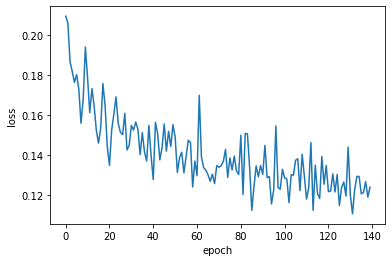

In [15]:
plt.plot(loss_)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'dice coefficient')

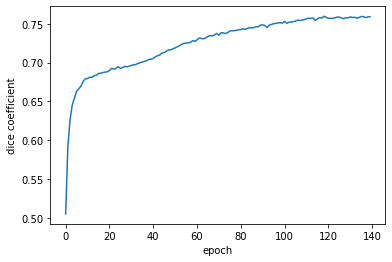

In [16]:
plt.plot(acc_)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')

In [17]:
model_path = '/home/zhangj41/HW/group_proj/Immune_cyto_models/unet_epoch130.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

34
torch.Size([100, 3, 64, 64]) torch.Size([100, 1, 64, 64]) torch.Size([100, 1, 64, 64])


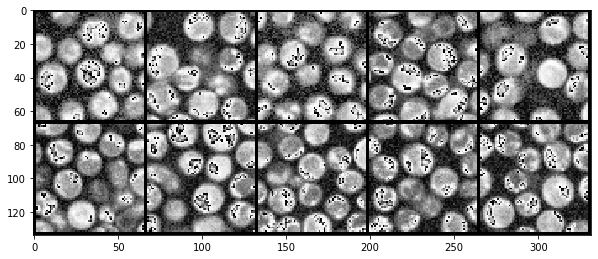

In [18]:
batch_datas, batch_labels = next(iter(DATALOADER_TEST)) 
batch_labels.unsqueeze_(1)

print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
img = make_grid(batch_datas[0:10], nrow=5, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()

pred_masks = model(batch_datas)
print(batch_datas.size(), batch_labels.size(), pred_masks.size())

torch.Size([3, 64, 64])


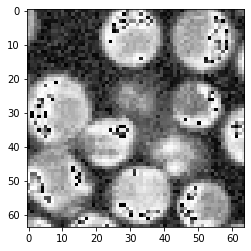

In [23]:
batch_data = batch_datas[1]
print(batch_data.size())
batch_data = batch_data.cpu().data.numpy()
plt.imshow(np.transpose(batch_data, (1,2,0)), cmap='gray', vmin=0, vmax=1)

torch.Size([64, 64])


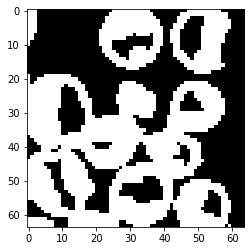

In [24]:
batch_label = batch_labels[1]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

torch.Size([64, 64])


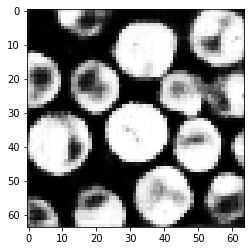

In [25]:
pred_mask = pred_masks[1]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

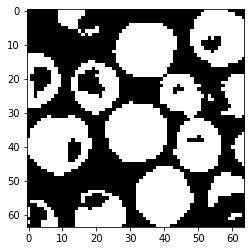

In [26]:
pred_mask[pred_mask>0.5] = 1
pred_mask[pred_mask<=0.5] = 0
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

## Metrics

In [14]:
model_path = '/home/zhangj41/HW/group_proj/Immune_cyto_models/unet_epoch130.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

solver = CellSeg(unet=model)
iou_avg, precision_avg, dice_coeff_avg = solver.eval_epoch(dataloader=DATALOADER_TEST)

Normal IOU of the dataset: 0.758868
Normal PREC of the dataset: 0.884478
Normal DICE SCORE of the dataset: 0.998653


## Whole Image

In [14]:
def img_preprocess(img_dir):
    image = imageio.imread(img_dir).astype("uint8")
    hist, bins = np.histogram(image, bins=256, range=[0,256])
    cum_hist = np.cumsum(hist)
    height, width = image.shape
    norm_cum_hist = cum_hist / (height * width)
    hists_cdf = (norm_cum_hist * 255).astype("uint8")
    # mapping
    img_eq = hists_cdf[image]
#     plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
    return img_eq

img_transform= transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [15]:
model_path = '/home/zhangj41/HW/group_proj/Immune_cyto_models/unet_epoch130.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

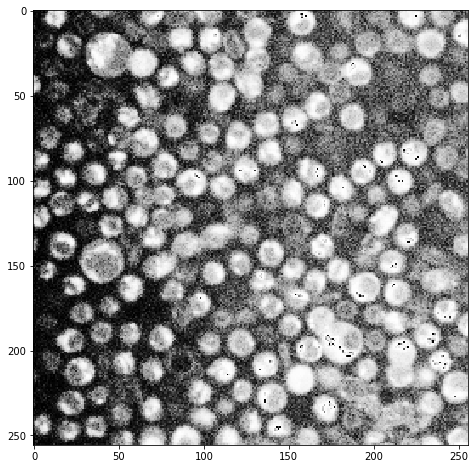

In [23]:
### read the whole image and convert to torch.Tensor
image_loc = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_1n_photons.tiff'
image_save = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_1n_photons.png'
cell_img = img_preprocess(img_dir=image_loc)
cell_img = Image.fromarray(cell_img)
cell_img.save(image_save)

imgs = Image.open(image_save).convert('RGB')
imgs = img_transform(imgs)

npimg = imgs.numpy()
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

torch.Size([256, 256])


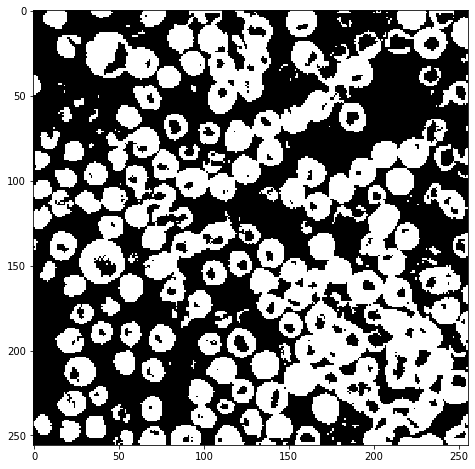

In [24]:
imgs.unsqueeze_(0)
imgs = imgs.cuda()
# imgs.size()

pred_mask = model(imgs)
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
pred_mask[pred_mask>=0.7] = 1
pred_mask[pred_mask<0.7] = 0

plt.figure(figsize=(8, 8))
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

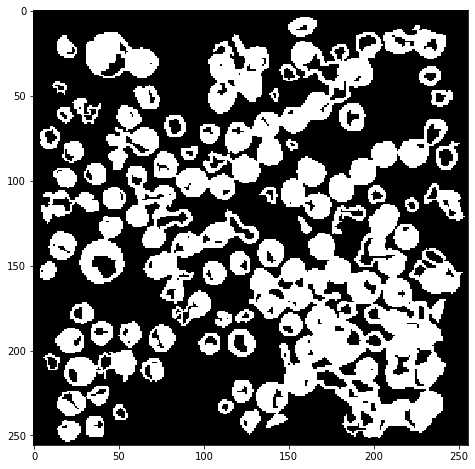

In [25]:
image_loc = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Masks/Tcells_Th0_1n_photons_cyto.tiff'
image = imageio.imread(image_loc).astype("uint8")

image[image>0.5] = 1
image[image<=0.5] = 0

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=0, vmax=1)